In [39]:
import experiments_func as exp
import matplotlib.pyplot as plt
import block_division_func as bd
import networkx as nx
import random
import math
import time

In [40]:
def compute_communication_cost(state, converter, num_blocks, linked_blocks, G):
    total_cost = 0
    for i in range(num_blocks):
        for j in linked_blocks[i]:
            if i >= num_blocks or j >= num_blocks:
                print(i, j)
            cost = nx.dijkstra_path_length(G, str(converter[state[i]]), str(converter[state[j]]))
            total_cost += cost
    return total_cost

# Function to generate a neighboring state
def generate_neighbor(state, num_blocks):
    neighbor = state.copy()
    task1, task2 = random.sample(range(num_blocks), 2)
    neighbor[task1], neighbor[task2] = neighbor[task2], neighbor[task1]
    return neighbor

# Function to calculate the acceptance probability
def acceptance_probability(delta_cost, temperature):
    if delta_cost < 0:
        return 1.0
    return math.exp(-delta_cost / temperature)

# Simulated annealing algorithm
def simulated_annealing(initial_state, converter, num_blocks, linked_blocks, G, max_iterations, initial_temperature, cooling_rate):
    current_state = initial_state.copy()
    best_state = current_state.copy()
    current_cost = compute_communication_cost(current_state, converter, num_blocks, linked_blocks, G)
    best_cost = current_cost
    temperature = initial_temperature

    for iteration in range(max_iterations):
        neighbor = generate_neighbor(current_state, num_blocks)
        neighbor_cost = compute_communication_cost(neighbor, converter, num_blocks, linked_blocks, G)
        delta_cost = neighbor_cost - current_cost

        if acceptance_probability(delta_cost, temperature) > random.random():
            current_state = neighbor
            current_cost = neighbor_cost

        if current_cost < best_cost:
            best_state = current_state.copy()
            best_cost = current_cost

        temperature *= cooling_rate

        # if iteration % 1000 == 0:
        #     converted_state = exp.convert_node_number(converter, current_state)
            # print(f'iteration: {iteration+1000}')
            # print(f'current_state: {converted_state}')
            # print(f'current_cost: {current_cost}\n')
    return best_state, best_cost

In [41]:
%%time

experiment = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]

# 焼きなまし法(simulated annealing)のパラメータ
max_iterations = 10000
initial_temperature = 100.0
cooling_rate = 0.95

random_nodes_random_result = []
random_nodes_random_SA_result = []
random_nodes_greedy_result = []
random_nodes_greedy_SA_result = []
top_nodes_random_result = []
top_nodes_random_SA_result = []
top_nodes_greedy_result = []
top_nodes_greedy_SA_result = []

# 実験環境
# GraphML形式のグラフを読み込む
G = nx.read_edgelist("/home/yamamoto/research/consideration_of_computer_power/src/data/japanese_network.edgelist", data=False)

# ノード番号を文字列から数字に変換する
# mapping = {node: i for i, node in enumerate(G.nodes())}
# G = nx.relabel_nodes(G, mapping)

pos = nx.spring_layout(G)
# nx.draw_networkx(G, pos)

# 分散処理に使用するPCの数
num_pcs = 50
# 分割するブロックの数
num_blocks_total = 55000

# ニューラルネットワークの分割ブロックの構造を表す
# structure_row = 2 # ブロックの行数
# structure_col = num_blocks_total // structure_row # ブロックの列数

# トポロジにある計算機の数
num_nodes = G.number_of_nodes()
# トポロジにある計算機にキャパシティを割り当てる
capacities = exp.generate_random_numbers(num_nodes, num_blocks_total)

# ランダムにノードを {num_pcs}個取得
random_nodes = exp.get_random_nodes(graph=G, num_pcs=num_pcs)
# ランダムノードのキャパシティ
random_capacities = [capacities[node] for node in random_nodes]

# 計算機群からキャパシティ上位{num_pcs}個の計算機を取得
top_indices = exp.get_top_n_indices(capacities, num_pcs)
# 上位ノードのキャパシティ
top_capacities = [capacities[node] for node in top_indices]
# 上位ノードの交流行列を作成
exchange_matrix = exp.generate_exchange_matrix(top_indices, num_pcs, G)

# ニューラルネットワークを分割したブロック
# block_structure = bd.generate_block_structure(row=structure_row, col=structure_col)

# 通信する必要のあるブロックのリストを作成(ブロックの接続関係)
# linked_blocks = bd.generate_linked_block_list(block_structure)

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 111 ms


In [42]:
for i, blocks in enumerate(experiment):
    
    # ニューラルネットワークの分割ブロックの構造を表す
    structure_row = 2 # ブロックの行数
    structure_col = blocks // structure_row # ブロックの列数
    
    # ニューラルネットワークを分割したブロック
    block_structure = bd.generate_block_structure(row=structure_row, col=structure_col)
    
    # 通信する必要のあるブロックのリストを作成(ブロックの接続関係)
    linked_blocks = bd.generate_linked_block_list(block_structure)

    # 分割するブロックの数(実験で使用する)
    num_blocks = blocks
    
    # 分割ブロックの番号リスト
    block_list = bd.generate_block_list(num_blocks=num_blocks)

    # ランダムに割り当てる
    # random_assigned_matrix = bd.generate_random_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=random_capacities)
    # random_random_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=random_assigned_matrix, converter=random_nodes, G=G)
    
    # ランダムにノードを選択し、ランダムに割り当てて、焼きなまし法を使って組み合わせ最適化
    # _, random_nodes_SA_total_cost = simulated_annealing(random_assigned_matrix, random_nodes, num_blocks, linked_blocks, G, max_iterations, initial_temperature, cooling_rate)

    # ランダムにノードを選択し、グリーディーに割り当て
    random_exchange_matrix = exp.generate_exchange_matrix(random_nodes, num_pcs, G)
    random_greedy_assigned_matrix = exp.generate_greedy_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=random_capacities, exchange_matrix=random_exchange_matrix)
    random_greedy_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=random_greedy_assigned_matrix, converter=random_nodes, G=G)

    # ランダムにノードを選択し、グリーディーに割り当て、焼きなまし法を使って組み合わせ最適化
    _, random_nodes_greedy_SA_total_cost = simulated_annealing(random_greedy_assigned_matrix, random_nodes, num_blocks, linked_blocks, G, max_iterations, initial_temperature, cooling_rate)
    
    
    # 上位のノードを選択し、ランダムに割り当てる
    # top_random_assigned_matrix = bd.generate_random_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=top_capacities)
    # top_random_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=top_random_assigned_matrix, converter=top_indices, G=G)

    # 上位のノードを選択し、ランダムに割り当てる、焼きなまし法を使って組み合わせ最適化
    # _, top_random_SA_total_cost = simulated_annealing(top_random_assigned_matrix, top_indices, num_blocks, linked_blocks, G, max_iterations, initial_temperature, cooling_rate)
    
    # 上位のノードを選択しグリーディーに割り当てる
    top_greedy_assigned_matrix = exp.generate_greedy_assignment(num_pcs=num_pcs, num_blocks=num_blocks, capacities=top_capacities, exchange_matrix=exchange_matrix)
    top_greedy_total_cost = exp.evaluate_communication_cost(block_list=block_list, linked_blocks=linked_blocks, assigned_matrix=top_greedy_assigned_matrix, converter=top_indices, G=G)

    # 上位のノードを選択しグリーディーに割り当てる、焼きなまし法を使って組み合わせ最適化
    _, top_greedy_SA_total_cost = simulated_annealing(top_greedy_assigned_matrix, top_indices, num_blocks, linked_blocks, G, max_iterations, initial_temperature, cooling_rate)
    
    print(f'{i+1}回目, ブロック数: {blocks}')
    # print(f'ランダムにノードを選択しランダムに割り当てた場合の総通信コスト: {random_random_total_cost}')
    # print(f'ランダムにノードを選択しランダムに割り当て、焼きなまし法を行った場合の総通信コスト: {random_nodes_SA_total_cost}')
    print(f'ランダムにノードを選択し提案手法で割り当てた場合の総通信コスト: {random_greedy_total_cost}')
    print(f'ランダムにノードを選択し提案手法で割り当て、焼きなまし法を行った場合の総通信コスト: {random_nodes_greedy_SA_total_cost}')
    # print(f'上位のノードを選択しランダムに割り当てた場合の総通信コスト: {top_random_total_cost}')
    # print(f'上位のノードを選択しランダムに割り当て、焼きなまし法を行った場合の総通信コスト: {top_random_SA_total_cost}')
    print(f'上位のノードを選択し提案手法で割り当てた場合の総通信コスト: {top_greedy_total_cost}')
    print(f'上位のノードを選択し提案手法で割り当て、焼きなまし法を行った場合の総通信コスト: {top_greedy_SA_total_cost}\n')
    
    # random_nodes_random_result.append(random_random_total_cost)
    # random_nodes_random_SA_result.append(random_nodes_SA_total_cost)
    random_nodes_greedy_result.append(random_greedy_total_cost)
    random_nodes_greedy_SA_result.append(random_nodes_greedy_SA_total_cost)
    # top_nodes_random_result.append(top_random_total_cost)
    # top_nodes_random_SA_result.append(top_random_SA_total_cost)
    top_nodes_greedy_result.append(top_greedy_total_cost)
    top_nodes_greedy_SA_result.append(top_greedy_SA_total_cost)

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

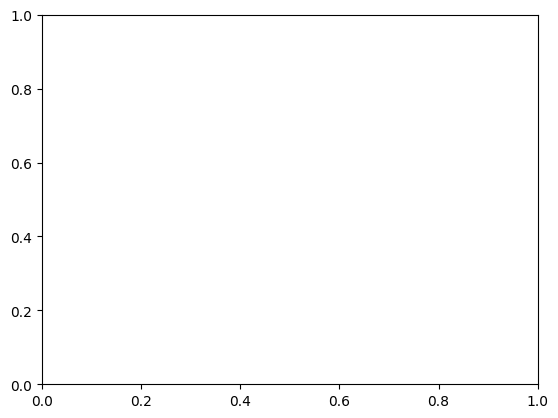

In [43]:
# グラフの設定
# plt.plot(experiment, random_nodes_random_result, label='Random_nodes + Random')
# plt.plot(experiment, random_nodes_random_SA_result, label='Random_nodes + Random + Simulated Annealing')
plt.plot(experiment, random_nodes_greedy_result, label='Random_nodes + Greedy')
plt.plot(experiment, random_nodes_greedy_SA_result, label='Random_nodes + Greedy + Simulated Annealing')
# plt.plot(experiment, top_nodes_random_result, label='top_nodes + Random')
# plt.plot(experiment, top_nodes_random_SA_result, label='top_nodes + Random + Simulated Annealing')
plt.plot(experiment, top_nodes_greedy_result, label='top_nodes + Greedy')
plt.plot(experiment, top_nodes_greedy_SA_result, label='top_nodes + Greedy + Simulated Annealing')

plt.xlabel('Number of Blocks')
plt.ylabel('Total Communication Cost')
plt.title('Experiment Results')
plt.legend()
# x軸の目盛り設定
plt.xticks(range(500, max(experiment)+1, 500))
# グラフの保存
plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/graph1.png')
# グラフの表示
plt.show()


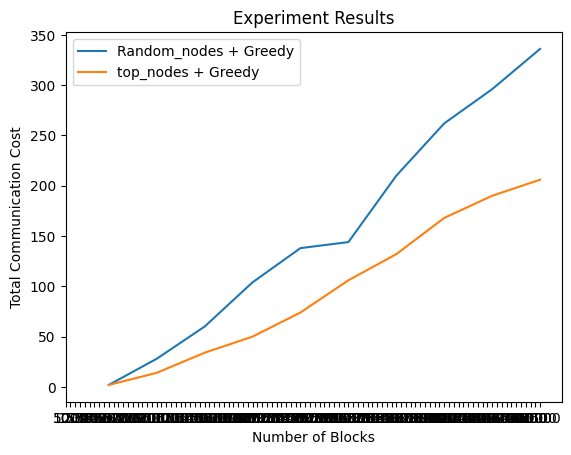

In [ ]:
plt.plot(experiment, random_nodes_greedy_result, label='Random_nodes + Greedy')
plt.plot(experiment, top_nodes_greedy_result, label='top_nodes + Greedy')

plt.xlabel('Number of Blocks')
plt.ylabel('Total Communication Cost')
plt.title('Experiment Results')
plt.legend()
# x軸の目盛り設定
plt.xticks(range(500, max(experiment)+1, 500))
# グラフの保存
plt.savefig('/home/yamamoto/research/consideration_of_computer_power/src/fig/graph2.png')
# グラフの表示
plt.show()
